In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *
from pylops.basicoperators import FirstDerivative

In [2]:
# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.imaging.kirchhoff import Kirchhoff
from pyfrac.utils.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage, wiggleplot
from pyfrac.visualisation.eventimages import locimage3d

# SETUP - MODEL, REC GEOM, SOURCES

In [3]:
outpath = '../../FDModelling/homoRB_DAS/'
expname = 'homoRB_DAS'

In [4]:
# MODEL
abs_bounds = 30 # boundary points

dx = dy = dz = 0.005  # 5mm
dimlims = 0.4 
nx = ny = nz = int(dimlims/dx) 
# dimlims = nx*dx

x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 5260

In [5]:
# RECEIVERS
recs = np.loadtxt(os.path.join(outpath,'inputs/receiver.dat')).T
recs = recs - (abs_bounds*dx)
nr = recs.shape[1]
print(nr)

36504


# LOAD DATA

In [6]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile, delimiter="\n")

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

In [7]:
# time shift for correct source ignition
tshift = 450 # index of source ignition

# SEISMIC DATA
vx = read_seis(os.path.join(outpath,'outputs/su/%s_vx.txt'%expname), nr)
vy = read_seis(os.path.join(outpath,'outputs/su/%s_vy.txt'%expname), nr)
vz = read_seis(os.path.join(outpath,'outputs/su/%s_vz.txt'%expname), nr)

# chopping data to reduce the size
vx = vx[:,tshift:1500] 
vy = vy[:,tshift:1500] 
vz = vz[:,tshift:1500] 
nt = vx.shape[1]

# SORTING INTO LINES

In [8]:
def strain_from_velocity(perp_velocity):
    '''
    perp_velocity follow pytorch dims: 'instance'-by-x-by-t
    e.g., [cable_no, x, t]
    where x is axis over which to differentiate
    '''
    # handle if only 1 instance, i.e. single rec line
    if len(perp_velocity.shape)==2: 
        perp_velocity = np.expand_dims(perp_velocity,axis=0)
    
    # Make differential operator
    diffOp = FirstDerivative(dims=perp_velocity.shape, 
                             axis=1, 
                             order=5)
    
    # Take differentiate over velocity direction
    strain = diffOp@perp_velocity    
    
    return strain

In [9]:
# ASSIGN RECEIVERS TO LINES
'''do not want to assign receivers on the limits (faces) to the 3rd orientation, 
i.e., we will not 'join' the first and last lines
''' 
o1_line_fixedpos = np.sort(np.unique(recs[0])) # Orientation 1
o2_line_fixedpos = np.sort(np.unique(recs[1])) # Orientation 2
o3_line_fixedpos = np.sort(np.unique(recs[2])) # Orientation 3

o1_assignment = np.zeros(len(recs.T))
o2_assignment = np.zeros(len(recs.T))
o3_assignment = np.zeros(len(recs.T))

for i,r in enumerate(recs.T):
    # Get each line assignment
    o1_assignment[i] = np.where(o1_line_fixedpos == r[0])[0]
    o2_assignment[i] = np.where(o2_line_fixedpos == r[1])[0]
    o3_assignment[i] = np.where(o3_line_fixedpos == r[2])[0]
    

In [10]:
np.min(recs[0])

0.0050000000000000044

# WORK ON FACE-BY-FACE BASIS AND CONVERT TO DAS

In [11]:
fx0_recs = np.where(recs[0] == np.min(recs[0]))[0]
recs_per_line = int(np.sqrt(len(fx0_recs)))

In [12]:
# X FACE - START
facex0_indices = np.where(recs[0] == np.min(recs[0]))[0]  # Face x=0

facex0_recs = recs.T[facex0_indices]
facex0_vy = vy[facex0_indices].reshape([recs_per_line,recs_per_line,nt])
facex0_vz = vz[facex0_indices].reshape([recs_per_line,recs_per_line,nt])

facex0_eps_y = strain_from_velocity(facex0_vy.transpose([1,0,2]))
facex0_eps_z = strain_from_velocity(facex0_vz)

# X FACE - END
facex1_indices = np.where(recs[0] == np.max(recs[0]))[0]  # Face x=Nx

facex1_recs = recs.T[facex1_indices]
facex1_vy = vy[facex1_indices].reshape([recs_per_line,recs_per_line,nt])
facex1_vz = vz[facex1_indices].reshape([recs_per_line,recs_per_line,nt])

facex1_eps_y = strain_from_velocity(facex1_vy.transpose([1,0,2]))
facex1_eps_z = strain_from_velocity(facex1_vz)

In [13]:
# Y FACE - START
facey0_indices = np.where(recs[1] == np.min(recs[1]))[0]  # Face x=0

facey0_recs = recs.T[facey0_indices]
facey0_vx = vx[facey0_indices].reshape([recs_per_line,recs_per_line,nt])
facey0_vz = vz[facey0_indices].reshape([recs_per_line,recs_per_line,nt])

facey0_eps_x = strain_from_velocity(facey0_vx.transpose([1,0,2]))
facey0_eps_z = strain_from_velocity(facey0_vz)

# Y FACE - END
facey1_indices = np.where(recs[1] == np.max(recs[1]))[0]  # Face x=Nx

facey1_recs = recs.T[facey1_indices]
facey1_vx = vx[facey1_indices].reshape([recs_per_line,recs_per_line,nt])
facey1_vz = vz[facey1_indices].reshape([recs_per_line,recs_per_line,nt])

facey1_eps_x = strain_from_velocity(facey1_vx)
facey1_eps_z = strain_from_velocity(facey1_vz)

In [14]:
# Z FACE - START
facez0_indices = np.where(recs[2] == np.min(recs[2]))[0]  # Face x=0

facez0_recs = recs.T[facez0_indices]
facez0_vx = vx[facez0_indices].reshape([recs_per_line,recs_per_line,nt])
facez0_vy = vy[facez0_indices].reshape([recs_per_line,recs_per_line,nt])

facez0_eps_x = strain_from_velocity(facez0_vx)
facez0_eps_y = strain_from_velocity(facez0_vy.transpose([1,0,2]))

# Z FACE - END
facez1_indices = np.where(recs[2] == np.max(recs[2]))[0]  # Face x=Nx

facez1_recs = recs.T[facez1_indices]
facez1_vx = vx[facez1_indices].reshape([recs_per_line,recs_per_line,nt])
facez1_vy = vy[facez1_indices].reshape([recs_per_line,recs_per_line,nt])

facez1_eps_x = strain_from_velocity(facez1_vx.transpose([1,0,2]))
facez1_eps_y = strain_from_velocity(facez1_vy.transpose([1,0,2]))

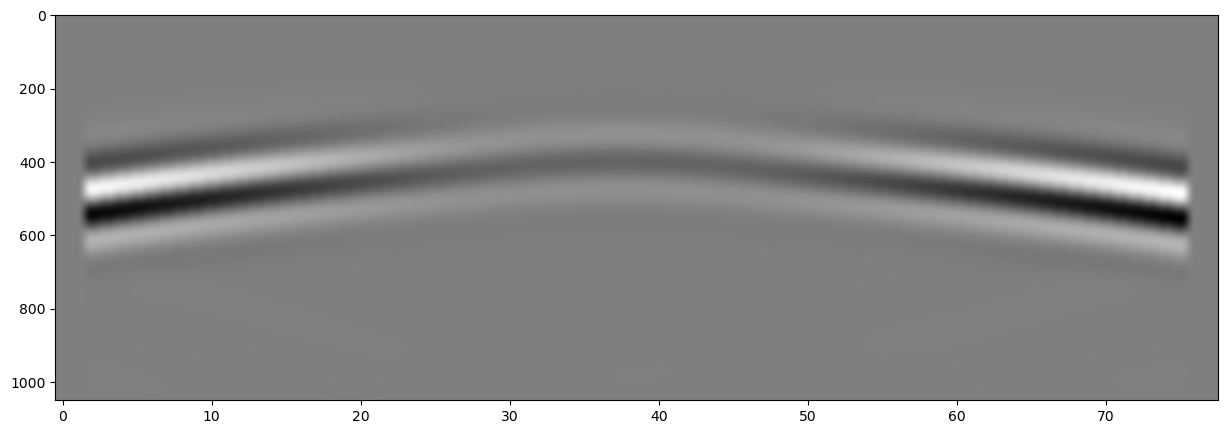

In [15]:
plt.figure(figsize=[15,5])
plt.imshow(facey1_eps_z[10].T,aspect='auto', cmap='binary')

In [16]:
facex0_eps_z[0].shape

(78, 1050)

# MAKE LINES

In [17]:
xlines = np.zeros([recs_per_line, 4*recs_per_line, nt])  # constant x
ylines = np.zeros([recs_per_line, 4*recs_per_line, nt])  # constant y
zlines = np.zeros([recs_per_line, 4*recs_per_line, nt])  # constant z


for xi in range(recs_per_line):
    xlines[xi] = np.vstack([facey0_eps_z[xi],facey1_eps_z[xi],facez0_eps_y[xi],facez1_eps_y[xi]])
    
for yi in range(recs_per_line):
    ylines[yi] = np.vstack([facex0_eps_z[yi],facex1_eps_z[yi],facez0_eps_x[yi],facez1_eps_x[yi]])
    
for zi in range(recs_per_line):
    zlines[zi] = np.vstack([facex0_eps_y[zi],facex1_eps_y[zi],facey0_eps_x[zi],facey1_eps_x[zi]])


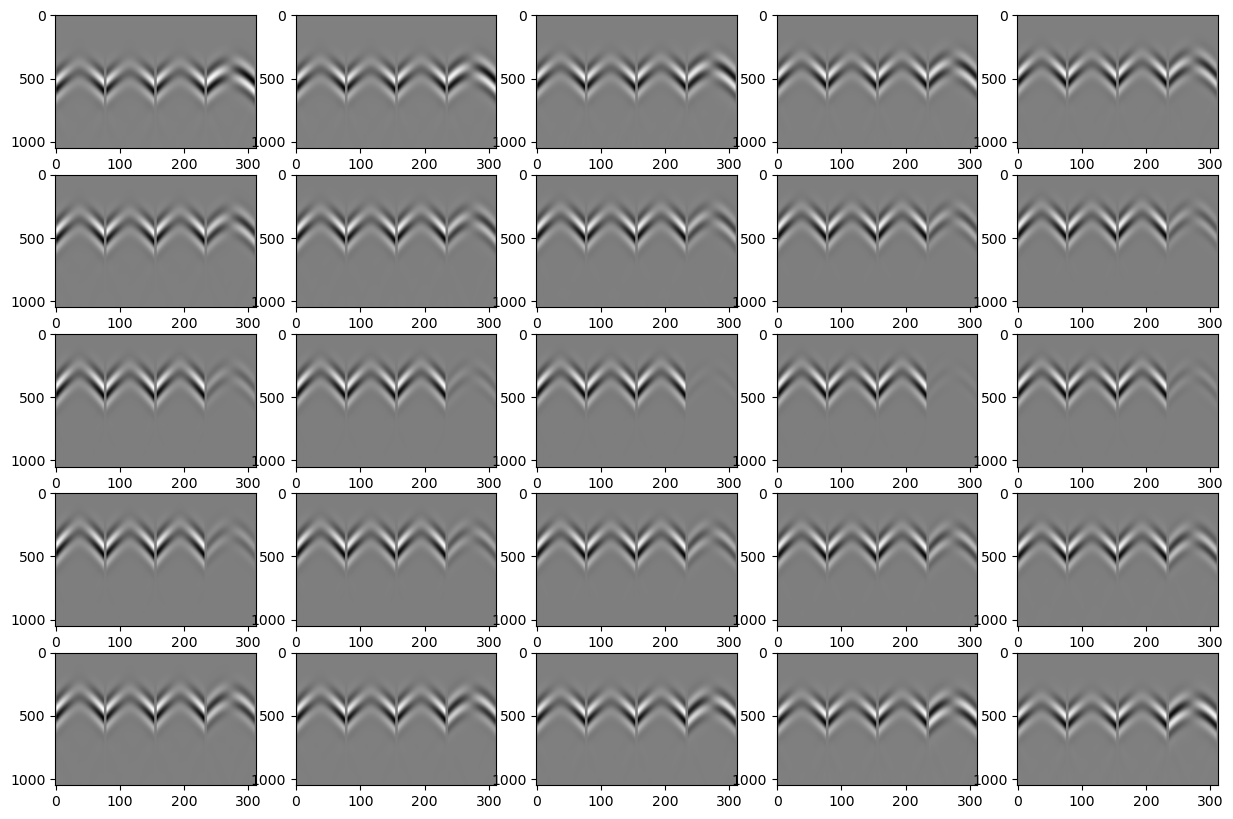

In [18]:
fig,axs = plt.subplots(5,5,figsize=[15,10])
for i,ax in enumerate(axs.ravel()):
    ax.imshow(zlines[i*3].T,aspect='auto', cmap='binary')